# Introducción
El trastorno por déficit de atención con hiperactividad (TDAH) se caracteriza por la actividad motora excesiva, la falta de atención y la impulsividad. HTR1B es un receptor de serotonina. Los polimorfismos del gen HTR1B se han relacionado con diversos trastornos psiquiátricos, como el trastorno por déficit de atención con hiperactividad (TDAH) y el trastorno obsesivo-compulsivo (TOC).

In [940]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score

# Dataset description

Este dataset fue prestado de un grupo de investigacion en la UdeA que busca asociar varios marcadores moleculares al desarrollo de TDAH, sin embargo tambien se tomaron otros metadatos, por ejemplo, género. Para este trabajo yo solo voy a evaluar el uso de receptores de serotonina (HTR) para este objetivo.

El dataset presenta las siguientes columnas 1.HTR1B (SNPs), TDAH (presencia), Edad, Género, NSE, adversidad, sin embargo para este trabajo solo se tiene en cuenta 1.HTR1B (SNPs), TDAH (presencia)y Género. Debido a que las demas variables son cergadas para la deteccion del TDAH, por ejemplo, la edad. Existen mas registros entre los 6 a los 20 años que por encima de los 20 años, esto probablemente debido a que es un transtorno que se aparece desde edades tempranas, por ende, tambien son de mas facil acceso para los especialistas.

In [941]:
dict_df=pd.read_excel(io="~/PiconCossio/data_science_class/DATOS-TDAH-R.xlsx",sheet_name=[1,2,3])

In [942]:
## Keeping only columns of interes and records only which have all the features.
keep_columns= ['CODIGO', '1.HTR1B', 'TDAH','Genero','2.HTR2A', '8.HTR2C']
df = dict_df[1].merge(dict_df[2][["2.HTR2A", "CODIGO"]], on="CODIGO", how="inner").merge(dict_df[3][["8.HTR2C", "CODIGO"]], on="CODIGO", how="inner")
df = df[keep_columns]
df.head()

,CODIGO,1.HTR1B,TDAH,Genero,2.HTR2A,8.HTR2C
0,HH015,1,1,1,2,5
1,HH016,1,0,2,1,3
2,HH022,2,1,1,2,5
3,HH023,2,0,2,3,3
4,HH024,1,0,2,1,2


In [943]:
df.replace({"Genero":2}, 0, inplace=True)

In [944]:
df.shape

(160, 6)

# First stadistical insights

Encuentro a *Edad* y *Genero* como las 2 unicas variables que podrian variar en terminos del muestreo, pues el restos de variables son variables categoricas tomadas para cada registro.
Asi, me encuentro que los codigos tienen variaciones entre el rango de edad y el género. Podemos empezar a notar que existe una diferencia entre el numero de datos tomados para ambos generos siendo el **2** el mas colectado. Asimismo el rango de edad entre **6 a 20 años** posee mayor numero de datos. Por lo que, podriamos empezara a **inferir** que nuestro modelo será mejor prediciendo TDAH en edades tempranas y en mujeres.

Siempre es mejor visualizar, o por lo menos soy una persona que prefiero graficar todo para visualizar tendencias, relaciones o  que simplemente me ayude a entender los datos.

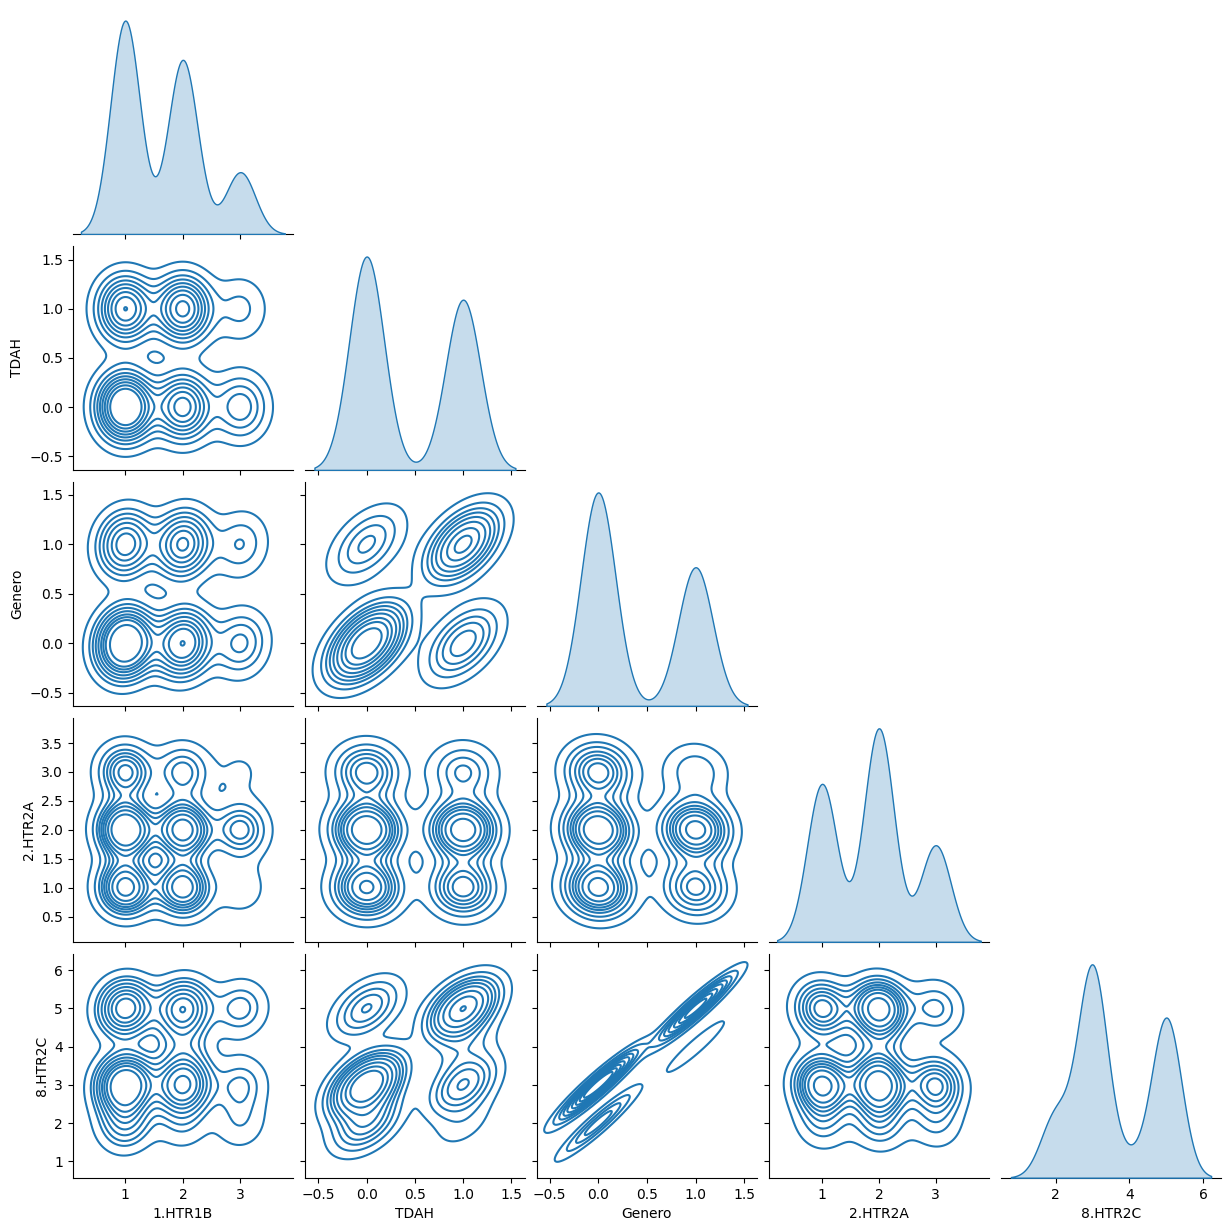

In [945]:
sns.pairplot(df, kind="kde", diag_kind="kde", corner=True)

In [946]:
# Existe una mayoria de registros para el genero femenino
df["Genero"].value_counts()

Genero
0    97
1    63
Name: count, dtype: int64

In [947]:
## Existen mas casos de TDAH para el femenino?
## Curiosamente no, hay mayor numero de casos positivos para el genero masculino
df.groupby("Genero")["TDAH"].sum()

Genero
0    24
1    47
Name: TDAH, dtype: int64

# Regresion logistica

Empecemos con algo simple. ¿Existe una relacion lineal entre los SNPs (1.HTR1B) con el desarrollo de TDAH (TDAH)? 

In [948]:
## Preproccesing
### La columna para el marcador molecular es una variable categorica, que emplea valores numericos (1,2,3). Emplearemos one-hot coding para evitar malinterpretación de valores categoricos.
df_transformed = pd.get_dummies(df, columns=["1.HTR1B", "2.HTR2A", "8.HTR2C"])
df_transformed.head()

,CODIGO,TDAH,Genero,1.HTR1B_1,1.HTR1B_2,1.HTR1B_3,2.HTR2A_1,2.HTR2A_2,2.HTR2A_3,8.HTR2C_2,8.HTR2C_3,8.HTR2C_4,8.HTR2C_5
0,HH015,1,1,True,False,False,False,True,False,False,False,False,True
1,HH016,0,0,True,False,False,True,False,False,False,True,False,False
2,HH022,1,1,False,True,False,False,True,False,False,False,False,True
3,HH023,0,0,False,True,False,False,False,True,False,True,False,False
4,HH024,0,0,True,False,False,True,False,False,True,False,False,False


In [949]:
df_transformed.iloc[:,3:].head()

,1.HTR1B_1,1.HTR1B_2,1.HTR1B_3,2.HTR2A_1,2.HTR2A_2,2.HTR2A_3,8.HTR2C_2,8.HTR2C_3,8.HTR2C_4,8.HTR2C_5
0,True,False,False,False,True,False,False,False,False,True
1,True,False,False,True,False,False,False,True,False,False
2,False,True,False,False,True,False,False,False,False,True
3,False,True,False,False,False,True,False,True,False,False
4,True,False,False,True,False,False,True,False,False,False


In [950]:
## Lets plot only those with a correlation higher than 0.1 or lower than -0.1
correlation_df = df_transformed.iloc[:,1:].corr().where((df_transformed.iloc[:,1:].corr() > 0.1) | (df_transformed.iloc[:,1:].corr() < -0.1))
correlation_df

,TDAH,Genero,1.HTR1B_1,1.HTR1B_2,1.HTR1B_3,2.HTR2A_1,2.HTR2A_2,2.HTR2A_3,8.HTR2C_2,8.HTR2C_3,8.HTR2C_4,8.HTR2C_5
TDAH,1.000000,0.490334,NaN,0.141697,-0.100913,NaN,NaN,NaN,-0.210502,-0.334807,0.220994,0.412584
Genero,0.490334,1.000000,-0.100544,NaN,NaN,NaN,0.134995,-0.126266,-0.321778,-0.757017,0.244924,0.923070
1.HTR1B_1,NaN,-0.100544,1.000000,-0.756571,-0.379786,NaN,NaN,NaN,NaN,NaN,-0.187751,NaN
1.HTR1B_2,0.141697,NaN,-0.756571,1.000000,-0.317581,NaN,NaN,NaN,-0.131317,NaN,0.248160,NaN
1.HTR1B_3,-0.100913,NaN,-0.379786,-0.317581,1.000000,NaN,0.144383,NaN,0.104084,NaN,NaN,NaN
2.HTR2A_1,NaN,NaN,NaN,NaN,NaN,1.000000,-0.653801,-0.363830,NaN,NaN,NaN,NaN
2.HTR2A_2,NaN,0.134995,NaN,NaN,0.144383,-0.653801,1.000000,-0.466936,NaN,-0.106082,0.149435,NaN
2.HTR2A_3,NaN,-0.126266,NaN,NaN,NaN,-0.363830,-0.466936,1.000000,NaN,NaN,-0.100617,NaN
8.HTR2C_2,-0.210502,-0.321778,NaN,-0.131317,0.104084,NaN,NaN,NaN,1.000000,-0.375053,NaN,-0.297023
8.HTR2C_3,-0.334807,-0.757017,NaN,NaN,NaN,NaN,-0.106082,NaN,-0.375053,1.000000,-0.185411,-0.698779


<Axes: >

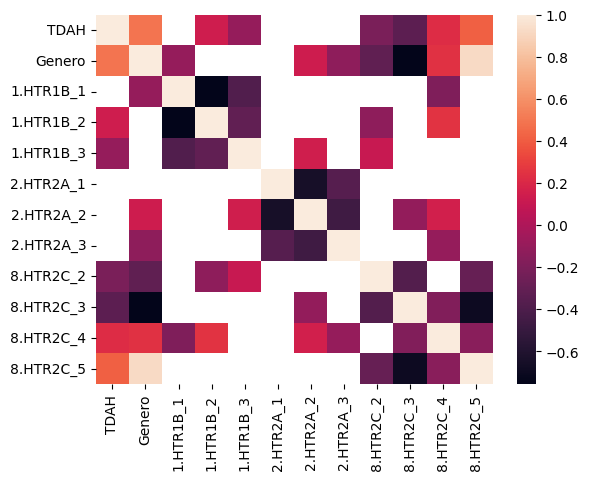

In [951]:
sns.heatmap(correlation_df)

In [952]:
df_transformed.iloc[:,3:].sum()

1.HTR1B_1    76
1.HTR1B_2    62
1.HTR1B_3    22
2.HTR2A_1    54
2.HTR2A_2    73
2.HTR2A_3    33
8.HTR2C_2    22
8.HTR2C_3    75
8.HTR2C_4     6
8.HTR2C_5    57
dtype: int64

## Observations

Mirando a la columna de TDAH, podemos observar una interesante correlación lineal mayor a 0.1 o menor a -0.1 entre los marcadores **1.HTR1B_2, 1.HTR1B_3, 8.HTR2C_2, 8.HTR2C_3, 8.HTR2C_4** y **8.HTR2C_5**, donde el receptor **8.HTR2C_5** presenta la mayor correlación positiva, mientras que el receptor **8.HTR2C_3** presenta la mayor correlación negativa. Al observar la cantidad de datos para cada receptor, encontramos que el receptor **8.HTR2C_4** presenta muy pocos datos, por lo que yo descartaría su correlación.

# Train model
1. train-test split
2. cross validation

In [953]:
# Lets remember the dataframe
df_transformed.head()
df_transformed.drop(df_transformed[df_transformed["8.HTR2C_4"]==True].index, inplace=True)
df_transformed.drop(["8.HTR2C_4"], axis=1, inplace=True)

## Using the only autosomal HTR

In [954]:
autosomal_htr = df_transformed.iloc[:,3:9]
autosomal_htr.head()

,1.HTR1B_1,1.HTR1B_2,1.HTR1B_3,2.HTR2A_1,2.HTR2A_2,2.HTR2A_3
0,True,False,False,False,True,False
1,True,False,False,True,False,False
2,False,True,False,False,True,False
3,False,True,False,False,False,True
4,True,False,False,True,False,False


In [955]:
## 1. train-test split using the htr autosomal

X_train, X_test, y_train, y_test = train_test_split(autosomal_htr,df_transformed["TDAH"].values , random_state=42,test_size=0.33, shuffle=True)
model_autosomal = LogisticRegression(class_weight="balanced", fit_intercept=False, penalty="l1", solver="liblinear")
model_autosomal.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', fit_intercept=False, penalty='l1',
                   solver='liblinear')

              precision    recall  f1-score   support

           0       0.48      0.62      0.54        26
           1       0.44      0.32      0.37        25

    accuracy                           0.47        51
   macro avg       0.46      0.47      0.46        51
weighted avg       0.47      0.47      0.46        51



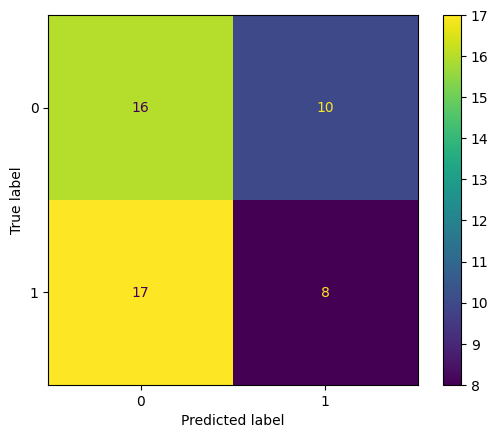

In [956]:
ConfusionMatrixDisplay.from_estimator(model_autosomal, X_test, y_test)
print(classification_report(y_test, model_autosomal.predict(X_test)))

In [957]:
print(classification_report(y_train, model_autosomal.predict(X_train)))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69        63
           1       0.50      0.47      0.49        40

    accuracy                           0.61       103
   macro avg       0.59      0.59      0.59       103
weighted avg       0.61      0.61      0.61       103



In [958]:
## 2. cross validation
score = cross_val_score(model_autosomal, autosomal_htr ,df_transformed["TDAH"].values, cv=3, scoring='precision_weighted')
print("score in each iteration: ",score)
print("Mean and std score by cross validation: ", score.mean(), score.std())

score in each iteration:  [0.47916667 0.45660857 0.4855615 ]
Mean and std score by cross validation:  0.47377891111551246 0.01241877454917774


In [959]:
feature_coefficients = pd.DataFrame({
    'Feature': autosomal_htr.columns,
    'Coefficient': model_autosomal.coef_[0]
})

print(feature_coefficients)

     Feature  Coefficient
0  1.HTR1B_1    -0.007240
1  1.HTR1B_2     0.452444
2  1.HTR1B_3    -0.317741
3  2.HTR2A_1    -0.259752
4  2.HTR2A_2     0.000000
5  2.HTR2A_3     0.000000


## Using both sexual and autosomal HTR

In [960]:
df_transformed.iloc[:,3:].head()

,1.HTR1B_1,1.HTR1B_2,1.HTR1B_3,2.HTR2A_1,2.HTR2A_2,2.HTR2A_3,8.HTR2C_2,8.HTR2C_3,8.HTR2C_5
0,True,False,False,False,True,False,False,False,True
1,True,False,False,True,False,False,False,True,False
2,False,True,False,False,True,False,False,False,True
3,False,True,False,False,False,True,False,True,False
4,True,False,False,True,False,False,True,False,False


In [961]:
## 1. train-test split using also the sexual chromosome htr

X_train, X_test, y_train, y_test = train_test_split(df_transformed.iloc[:,3:],df_transformed["TDAH"].values , random_state=42,test_size=0.3, shuffle=True)
model = LogisticRegression(class_weight='balanced', fit_intercept=False, solver="liblinear", penalty="l1")
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', fit_intercept=False, penalty='l1',
                   solver='liblinear')

In [962]:
## 2. cross validation
score = cross_val_score(model, df_transformed.iloc[:,3:],df_transformed["TDAH"].values, cv=3, scoring="recall_weighted")
print("score in each iteration: ",score)
print("Mean and std score by cross validation: ", score.mean(), score.std())

score in each iteration:  [0.73076923 0.74509804 0.68627451]
Mean and std score by cross validation:  0.7207139265962796 0.025045076157761557


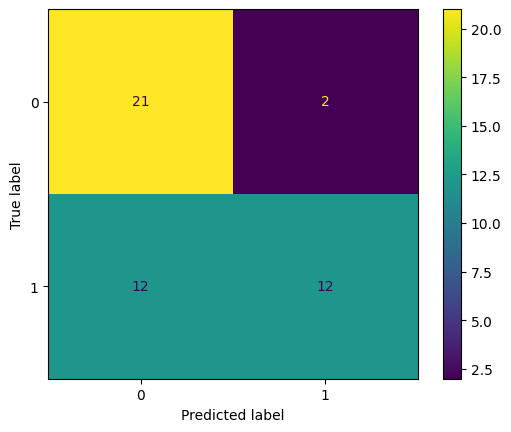

In [963]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [964]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.91      0.75        23
           1       0.86      0.50      0.63        24

    accuracy                           0.70        47
   macro avg       0.75      0.71      0.69        47
weighted avg       0.75      0.70      0.69        47



In [965]:
feature_coefficients = pd.DataFrame({
    'Feature': X_test.columns,
    'Coefficient': model.coef_[0]
})

print(feature_coefficients)

     Feature  Coefficient
0  1.HTR1B_1     0.000000
1  1.HTR1B_2     0.248685
2  1.HTR1B_3    -0.621345
3  2.HTR2A_1    -0.362068
4  2.HTR2A_2     0.000000
5  2.HTR2A_3     0.000000
6  8.HTR2C_2    -0.251291
7  8.HTR2C_3    -0.843998
8  8.HTR2C_5     1.213059


## Using only the sexual HTR

In [966]:
df_transformed.iloc[:,9:].head()

,8.HTR2C_2,8.HTR2C_3,8.HTR2C_5
0,False,False,True
1,False,True,False
2,False,False,True
3,False,True,False
4,True,False,False


In [967]:
## Using only the sexual htr
X_train, X_test, y_train, y_test = train_test_split(df_transformed.iloc[:,9:],df_transformed["TDAH"].values , random_state=42,test_size=0.3, shuffle=True)
model = LogisticRegression(class_weight='balanced', fit_intercept=False, solver="liblinear", penalty="l1")
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', fit_intercept=False, penalty='l1',
                   solver='liblinear')

In [968]:
score = cross_val_score(model, df_transformed.iloc[:,9:],df_transformed["TDAH"].values, cv=3, scoring="f1_weighted")
print("score in each iteration: ",score)
print("Mean and std score by cross validation: ", score.mean(), score.std())

score in each iteration:  [0.72877493 0.73887333 0.71066159]
Mean and std score by cross validation:  0.726103282308419 0.011671297674460911


In [969]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.91      0.75        23
           1       0.86      0.50      0.63        24

    accuracy                           0.70        47
   macro avg       0.75      0.71      0.69        47
weighted avg       0.75      0.70      0.69        47



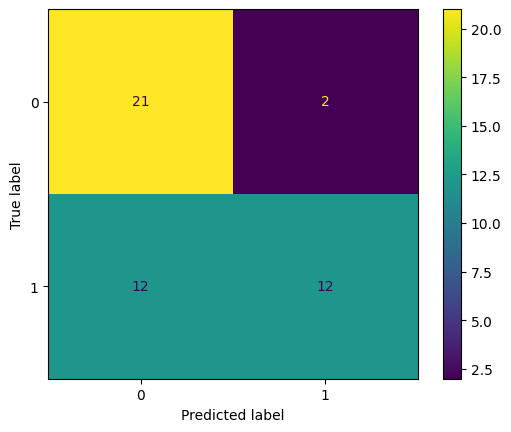

In [970]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [971]:
feature_coefficients = pd.DataFrame({
    'Feature': X_test.columns,
    'Coefficient': model.coef_[0]
})

feature_coefficients

,Feature,Coefficient
0,8.HTR2C_2,-0.476753
1,8.HTR2C_3,-0.927995
2,8.HTR2C_5,1.093089


# Only HTR in males

In [972]:
only_males = df_transformed[df_transformed["Genero"] == 1]
only_males.shape

(57, 12)

In [973]:
only_males.drop(["8.HTR2C_2","8.HTR2C_3"], axis=1, inplace=True)

/tmp/ipykernel_19345/1718173433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_males.drop(["8.HTR2C_2","8.HTR2C_3"], axis=1, inplace=True)


In [974]:
##  no es un dataset muy desbalanceado minoria > 20% sin embargo son muy pocos los datos
## 1. train-test split using also the sexual chromosome htr
X_train, X_test, y_train, y_test = train_test_split(only_males.iloc[:,3:],only_males["TDAH"].values , random_state=42,test_size=0.3, shuffle=True)
model_male = LogisticRegression(class_weight="balanced", fit_intercept=False, solver="liblinear", penalty="l1")
model_male.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', fit_intercept=False, penalty='l1',
                   solver='liblinear')

In [975]:
## 2. cross validation
score = cross_val_score(model_male, only_males.iloc[:,3:],only_males["TDAH"].values, cv=3, scoring="recall_weighted")
print("score in each iteration: ",score)
print("Mean and std score by cross validation: ", score.mean(), score.std())

score in each iteration:  [0.31578947 0.31578947 0.47368421]
Mean and std score by cross validation:  0.3684210526315789 0.07443229275647868


In [976]:
feature_coefficients = pd.DataFrame({
    'Feature': X_test.columns,
    'Coefficient': model_male.coef_[0]
})

feature_coefficients

,Feature,Coefficient
0,1.HTR1B_1,2.429462e-01
1,1.HTR1B_2,7.696104e-02
2,1.HTR1B_3,-7.559481e-01
3,2.HTR2A_1,0.000000e+00
4,2.HTR2A_2,0.000000e+00
5,2.HTR2A_3,0.000000e+00
6,8.HTR2C_5,1.156068e-11


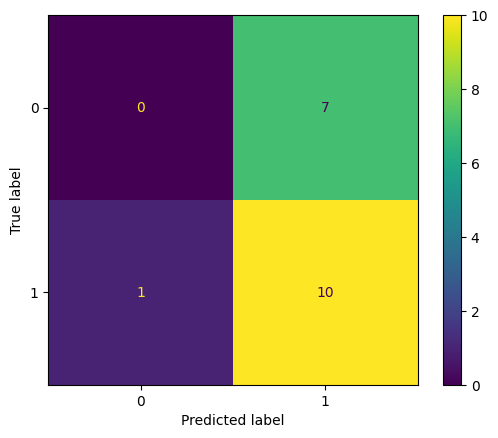

In [977]:
ConfusionMatrixDisplay.from_estimator(model_male, X_test, y_test)

In [978]:
print(classification_report(y_test, model_male.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.59      0.91      0.71        11

    accuracy                           0.56        18
   macro avg       0.29      0.45      0.36        18
weighted avg       0.36      0.56      0.44        18



In [979]:
only_males.sum()

CODIGO       HH015HH022HH027HH028HH031HH057HH059HH064HH078H...
TDAH                                                        41
Genero                                                      57
1.HTR1B_1                                                   26
1.HTR1B_2                                                   22
1.HTR1B_3                                                    9
2.HTR2A_1                                                   19
2.HTR2A_2                                                   29
2.HTR2A_3                                                    9
8.HTR2C_5                                                   57
dtype: object

# Only females

In [980]:
only_females = df_transformed[df_transformed["Genero"] == 0]
only_females.shape

(97, 12)

In [981]:
only_females.drop(["8.HTR2C_5"], axis=1, inplace=True)

/tmp/ipykernel_19345/2094742095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_females.drop(["8.HTR2C_5"], axis=1, inplace=True)


In [982]:
## 1. train-test split using also the sexual chromosome htr
X_train, X_test, y_train, y_test = train_test_split(only_females.iloc[:,3:],only_females["TDAH"].values , random_state=42,test_size=0.1, shuffle=True)
model_female = LogisticRegression(class_weight="balanced", fit_intercept=False, solver="liblinear", penalty="l1")
model_female.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', fit_intercept=False, penalty='l1',
                   solver='liblinear')

In [983]:
## 2. cross validation
score = cross_val_score(model_female, only_females.iloc[:,3:],only_females["TDAH"].values, cv=3, scoring="recall_weighted")
print("score in each iteration: ", score)
print("Mean and std score by cross validation: ", score.mean(), score.std())

score in each iteration:  [0.57575758 0.34375    0.34375   ]
Mean and std score by cross validation:  0.42108585858585856 0.109369420069889


In [984]:
feature_coefficients = pd.DataFrame({
    'Feature': X_test.columns,
    'Coefficient': model_female.coef_[0]
})

feature_coefficients

,Feature,Coefficient
0,1.HTR1B_1,0.000000
1,1.HTR1B_2,0.148737
2,1.HTR1B_3,-0.295560
3,2.HTR2A_1,0.119585
4,2.HTR2A_2,0.000000
5,2.HTR2A_3,-0.153575
6,8.HTR2C_2,-0.055895
7,8.HTR2C_3,0.000000


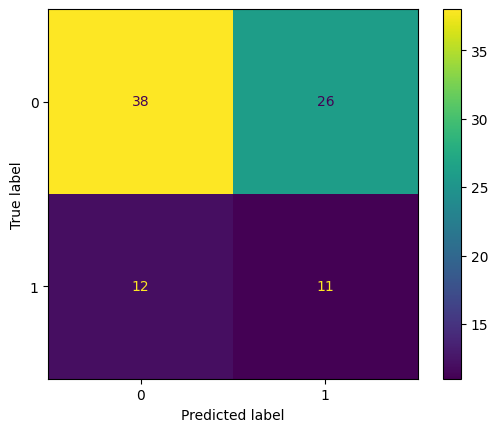

In [985]:
ConfusionMatrixDisplay.from_estimator(model_female, X_train, y_train)

In [986]:
only_females.sum()

CODIGO       HH016HH023HH024HH060HH063HH073HH074HH075HH081H...
TDAH                                                        24
Genero                                                       0
1.HTR1B_1                                                   50
1.HTR1B_2                                                   34
1.HTR1B_3                                                   13
2.HTR2A_1                                                   34
2.HTR2A_2                                                   39
2.HTR2A_3                                                   24
8.HTR2C_2                                                   22
8.HTR2C_3                                                   75
dtype: object